## Global optimum using gradient descent and analytic model

In [65]:
%reload_ext autoreload
%autoreload 2

import gurobipy as gp
import networkx as nx
import numpy as np
from spice_net import *
from helpers import *

In [121]:
def analytic_solve(net: LinearNetwork, inputs, targets):
    # construct the model and circuit matrix
    n = len(net.__nodes__[1:])
    m = len(net.inputs)
    B = np.zeros((n, m))
    C = B.T
    D = np.zeros((m, m))

    model = gp.Model(net.name)

    # populate G with resistor values
    res_cfg = []
    res_vars = []
    for i, R in enumerate(net.edges):
        i, j = list(map(lambda i: int(i)-1, R.node_names))
        mat = np.zeros((m+n, m+n))
        if min(i, j) >= 0:
            mat[i, j] = mat[j, i] = -1

            mat[i, i] = 1
            mat[j, j] = 1
        else:
            mat[max(i, j), max(i, j)] = 1
        
        res_vars.append(model.addMVar(1, name=f'R{i}', lb=0))
        res_cfg.append(mat)

    for k, V in enumerate(net.inputs):
        i, j = list(map(lambda i: int(i)-1, V.node_names))
        if i >= 0:
            B[i, k] = 1
        if j >= 0:
            B[j, k] = -1

    constant_part = np.block([[np.zeros((n, n)), B], [C, D]])

    # prepare the data matrices
    n_examples = inputs.shape[0]
    output_dim = targets.shape[1]

    inputs = inputs.T

    downsampler = np.zeros((output_dim, m+n))

    for k, V in enumerate(net.outputs):
        i, j = list(map(lambda i: int(i)-1, V.node_names))
        downsampler[k, i] = 1
        downsampler[k, j] = -1
    
    X = np.concatenate((np.zeros((n, n_examples)), inputs))

    A = model.addMVar((m+n, m+n), name='A')
    v = model.addMVar((n_examples, m+n), name='v')
    model.addConstrs(A[i] @ v[j] == X[i, j] for i in range(m+n) for j in range(n_examples))
    for i in range(m+n):
        for j in range(m+n):
            model.addConstr(0 == A[i, j] - constant_part[i, j] - gp.quicksum(r * M[i, j] for r, M in zip(res_vars, res_cfg))) # for i in range(m+n) for j in range(m+n))

    dummy = model.addMVar(targets.shape, name='dummy')
    model.addConstrs(dummy[i] == downsampler @ v[i] - targets[i] for i in range(n_examples))
    model.setObjective(gp.quicksum(dummy[i, :] @ dummy[i, :] for i in range(n_examples)), gp.GRB.MINIMIZE)

    model.optimize()

    return model

In [67]:
# Fixed parameters
nodes = 8
edge_prob = .5

in_nodes = 2
out_nodes = 1

In [131]:
xs = np.logspace(-10, 0, 10)
c = 1e-4
-c * np.log(xs)

array([ 0.00230259,  0.00204674,  0.0017909 ,  0.00153506,  0.00127921,
        0.00102337,  0.00076753,  0.00051169,  0.00025584, -0.        ])

In [68]:
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

for i, (u, v) in enumerate(con_graph.edges()):
    con_graph[u][v]['type'] = 'resistor'
    con_graph[u][v]['weight'] = weights[i]

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

out_plus = node_cfg[1][0][0]
out_minus = node_cfg[1][0][1]

net = LinearNetwork('test', con_graph, node_cfg)

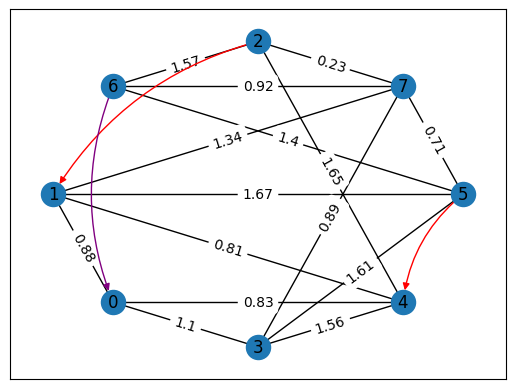

In [69]:
visualize(net)

In [70]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

In [71]:
# Generate target outputs
ys = xs_bias @ np.random.normal(0, 1, size=(2, 1))

In [125]:
sol = analytic_solve(net, xs_bias, ys)

GurobiError: Unsupported type (<class 'gurobipy.MQuadExpr'>) for LinExpr addition argument